** Figure 2: Global fragment size distribution **

We start with creating the heatmap and histogram shown in Fig 2a. For this, we use the output files of Picard's CollectInsertSizeMetrics.

In [5]:
%%bash
wget http://medical-epigenomics.org/papers/peneder2020_f17c4e3befc643ffbb31e69f43630748/data/fragment_size.tar.gz #if needed, update with the path of the downloaded data directory on your system
tar -xzf fragment_size.tar.gz

We also need to load details about the samples, both clinical and genome-based:

In [17]:
import pandas as pd
import glob
from matplotlib import pyplot as plt
import numpy as np

clinical=pd.read_excel("../tables/Supplementary Table 1_Patient cohort.xlsx","Patient clinical data")
genomic=pd.read_excel("../tables/Supplementary Table 2_ctDNA quantification.xlsx","Genomic ctDNA quantification")
# note that in these two tables and the files other provided on this website, Rhabdomyosarcoma samples are encoded as "Rha" instead of "RMS"

non_ews_cancers=list(clinical[clinical["Sample type"]=="Non-EwS sarcoma"]["Sample"].values)
fixation_excluded_samples=list(genomic[genomic["Excluded due to fixation (1=yes)"]==1]["Sample"].values)
size_selected=list(genomic[genomic["Excluded due to size selection prior to library preparation (1=yes)"]==1]["Sample"].values)
controls=list(clinical[clinical["Sample type"]=="Healthy control"]["Sample"].values)

ews_samples_to_plot=genomic[~genomic["Sample"].isin(size_selected+fixation_excluded_samples+non_ews_cancers+controls)]
zero_perc=list(ews_samples_to_plot[ews_samples_to_plot["Combined quantification: % ctDNA"]==0]["Sample"].values)
upto20_perc=list(ews_samples_to_plot[(ews_samples_to_plot["Combined quantification: % ctDNA"]>0) & (ews_samples_to_plot["Combined quantification: % ctDNA"]<=20)]["Sample"].values)
morethan20_perc=list(ews_samples_to_plot[(ews_samples_to_plot["Combined quantification: % ctDNA"]>20)]["Sample"].values)
non_ews_cancers_to_plot=[x for x in non_ews_cancers if not x in size_selected+fixation_excluded_samples]


In [18]:
# Turns Picard's output into a python dict
def get_frag_distro(fraglen_histo,cumul, start_from):
    fdict={}
    total=0
    with open(fraglen_histo) as f:
        counter=False
        for line in f:
            if line.startswith("insert_size"):
                counter=True
                continue
            if counter and line.replace("\n",""):
                size,nr=line.split()
                if int(size)>=start_from:
                    total+=int(nr)
                    if cumul:
                        fdict[int(size)]=int(total)
                    else:
                        fdict[int(size)]=int(nr)
    return fdict

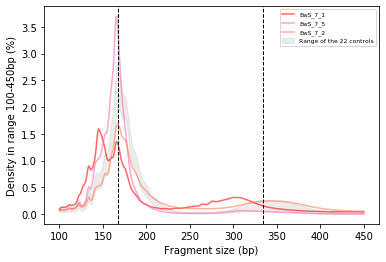

In [19]:
# A few basic settings:
insertfolder="fragment_size"
relative_over_zoom_only=True
zoomed_area_start=100
zoomed_area_end=450
log_vs_ctrl=True

samplenamelist=[sample.replace("_insertsizemetrics.txt","").split("/")[-1] for sample in glob.glob(insertfolder+"/*insertsizemetrics.txt")]
distrofilelist=glob.glob(insertfolder+"/*insertsizemetrics.txt")

#this stores the fragment size distribution of every sample:
sampledict={}

for distrofile in distrofilelist:
    samplename=distrofile.replace("_insertsizemetrics.txt","").split("/")[-1]
    if samplename not in list(ews_samples_to_plot["Sample"].values)+non_ews_cancers_to_plot+controls:
        continue
    fragdict=get_frag_distro(distrofile,False,0)

    # In case a value is missing in the provided histogram, fill it with 0 or the previous value
    fragdict_full={}
    for i in range(0,801):
        if i in fragdict.keys():
            fragdict_full[i]=fragdict[i]
        else:
            fragdict_full[i]=0
    fragdict=fragdict_full

    # devide by the total if relative
    if relative_over_zoom_only:
        allcounts=sum([value for key,value in fragdict.items() if zoomed_area_start<=key<=zoomed_area_end])
    else:
        allcounts=sum([value for value in fragdict.values()])

    fragdict={key:100*value/allcounts for key, value in fragdict.items()}
    fragweights_for_plot=list(fragdict.values())

    sampledict[samplename]=fragweights_for_plot[zoomed_area_start:zoomed_area_end+1]

for sample,col in zip(["EwS_7_1","EwS_7_5","EwS_7_2"],["red","hotpink","coral"]):
    plt.plot(list(range(zoomed_area_start,zoomed_area_end+1)),sampledict[sample],alpha=0.6,label="%s"%(sample),color=col) 

# Plot range of healthy controls as grey area    
ctrl_y_vals=[]
for sample in sampledict.keys():
    if not "Ctrl" in sample:
        continue
    ctrl_y_vals.append(sampledict[sample])
min_ctrls=[]
max_ctrls=[]
for i in range(len(ctrl_y_vals[0])):
    min_ctrls.append(min([yvallist[i] for yvallist in ctrl_y_vals]))
    max_ctrls.append(max([yvallist[i] for yvallist in ctrl_y_vals]))
plt.fill_between(list(range(zoomed_area_start,zoomed_area_end+1)),min_ctrls,max_ctrls,alpha=0.15, label="Range of the "+str(len(ctrl_y_vals))+" controls",color="grey")
plt.legend(fontsize=6)
plt.axvline(167*2,linewidth=1, color="black", alpha=1,zorder=10,linestyle="--")
plt.axvline(167,linewidth=1, color="black", alpha=1,linestyle="--",zorder=10)
plt.ylabel("Density in range 100-450bp (%)")
plt.xlabel("Fragment size (bp)")
plt.show()

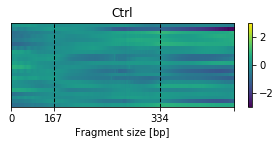

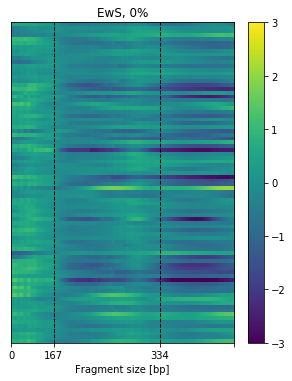

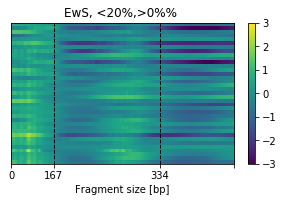

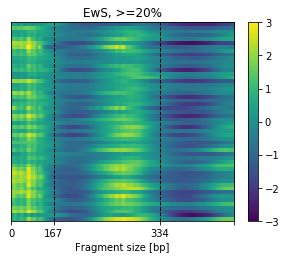

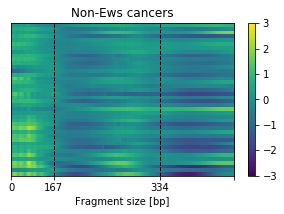

In [20]:
# Now, we create a heatmap of all relevant samples:

df=pd.DataFrame(sampledict)
df=df.transpose()
df.columns=list(range(zoomed_area_start,zoomed_area_end+1))

# Using the difference to the median of controls makes the signal more clearly visible
if log_vs_ctrl:
    median_ctrl=df.loc[controls].median()
    df_log=df/median_ctrl
    df_log=np.log2(df_log)
    df=df_log

# Max and min of the colorbar
mymax=3
mymin=-3

for sampleset,samplesetname in zip([controls,zero_perc,upto20_perc,morethan20_perc,non_ews_cancers_to_plot],["Ctrl","EwS, 0%","EwS, <20%,>0%% ","EwS, >=20%","Non-Ews cancers"]):

    # within each group, order by tumor content
    samplesetdf=df.loc[sampleset]
    samplesetdf["Combined quantification: % ctDNA"]=samplesetdf.apply(lambda row: genomic[genomic["Sample"]==row.name]["Combined quantification: % ctDNA"].values[0],axis=1)
    samplesetdf=samplesetdf.sort_values(by="Combined quantification: % ctDNA")
    samplesetdf=samplesetdf.drop("Combined quantification: % ctDNA",axis=1)

    ax1=plt.gca()

    # set size of plots according to the nr. of samples in the group
    plt.gcf().set_size_inches(5,len(sampleset)/10)
    plt.imshow(samplesetdf,aspect='auto',vmin=mymin,vmax=mymax)#
    plt.colorbar()
    plt.xticks([0,167-zoomed_area_start,334-zoomed_area_start,zoomed_area_end-zoomed_area_start],[0,167,334])
    plt.yticks([],[])
    plt.xlabel("Fragment size [bp]")
    plt.subplots_adjust(bottom=0.35)

    plt.axvline(167*2-zoomed_area_start,linewidth=1, color="black", alpha=1,zorder=10,linestyle="--")
    plt.axvline(167-zoomed_area_start,linewidth=1, color="black", alpha=1,linestyle="--",zorder=10)
    plt.title(samplesetname)
    plt.show()
   
    samplesetdf["local max"]=samplesetdf.apply(lambda row: zoomed_area_start+list(row.values).index(row.max()),axis=1)
    samplesetdf.to_csv(samplesetname.replace(" ","_")+".csv")


Finally, we produce a table of features of global fragmentation, which can then easily be compared to results from Mouliere et al, and used for machine learning:

In [21]:
insertfolder="fragment_size"
zoomed_area_start=20 # for plots only
zoomed_area_end=450 # for plots only
plot=False # Set to True to generate plots for all samples

samplenamelist=[sample.replace("_insertsizemetrics.txt","").split("/")[-1] for sample in glob.glob(insertfolder+"/*insertsizemetrics.txt")]
distrofilelist=glob.glob(insertfolder+"/*insertsizemetrics.txt")

#this stores the fragment size distribution of every sample:
distrodict={}
# Stores fragmentation-based features of all samples:
featuredict={}

for distrofile in distrofilelist:
    sample_featuredict={}
    samplename=distrofile.replace("_insertsizemetrics.txt","").split("/")[-1]
    if samplename not in list(ews_samples_to_plot["Sample"].values)+non_ews_cancers_to_plot+controls:
        continue
    fragdict=get_frag_distro(distrofile,False,0)

    # In case a value is missing in the provided histogram, fill it with 0 or the previous value
    fragdict_full={}
    for i in range(0,801):
        if i in fragdict.keys():
            fragdict_full[i]=fragdict[i]
        else:
            fragdict_full[i]=0
    fragdict=fragdict_full
    allcounts=sum([value for value in fragdict.values()])
    fragdict={key:value/allcounts for key, value in fragdict.items()}
    fragweights_for_plot=list(fragdict.values())
    distrodict[samplename]=fragweights_for_plot[zoomed_area_start:zoomed_area_end+1]
    
    # Fragment based features, mainly from Mouliere et al.
    for start,end in [(20,150),(100,150),(125,180),(160,180),(180,220),(250,320),]:
        sample_featuredict["P("+str(start)+"_"+str(end)+")"]=sum(fragweights_for_plot[start:end])
    sample_featuredict["P(160_180)/P(180_220"]=sum(fragweights_for_plot[160:180])/sum(fragweights_for_plot[180:220])
    sample_featuredict["P(20_150)/P(160_180)"]=(sum(fragweights_for_plot[20:150])/sum(fragweights_for_plot[160:180]))
    sample_featuredict["P(100_150)/P(163_169)"]=(sum(fragweights_for_plot[100:150])/sum(fragweights_for_plot[163:169]))
    sample_featuredict["P(20_150)/P(180_220)"]=(sum(fragweights_for_plot[20:150])/sum(fragweights_for_plot[180:220]))

    # From Mouliere et al.
    local_minima=[84, 96, 106, 116, 126, 137, 148]
    local_maxima=[81, 92, 102, 112, 122, 134, 144]

    # to test whether Mouliere et al.'s positions local minima and maxima are similar to ours:
    """
    my_local_max=[75+x for x in argrelextrema(np.array(fragweights_for_plot[75:150]), np.greater)]
    my_local_min=[75+x for x in argrelextrema(np.array(fragweights_for_plot[75:150]), np.less)]
    my_local_max_smooth=[75+x for x in argrelextrema(np.array(ndimage.gaussian_filter(fragweights_for_plot[75:150],mode="nearest",sigma=1)), np.greater)]
    my_local_min_smooth=[75+x for x in argrelextrema(np.array(ndimage.gaussian_filter(fragweights_for_plot[75:150],mode="nearest",sigma=1)), np.less)]
    print("##### MIN/MAX ###")
    print(my_local_min)
    print(my_local_max)
    print("##### MIN/MAX SMOOTH ###")
    print(my_local_min_smooth)
    print(my_local_max_smooth)
    """
    periodicity=sum([fragweights_for_plot[x] for x in local_maxima])-sum([fragweights_for_plot[x] for x in local_minima])
    sample_featuredict["amplitude_10bp"]=periodicity
    featuredict[samplename]=sample_featuredict

df=pd.DataFrame(featuredict)
df.transpose().to_csv("global_fragmentation_features.csv")

if plot:
    # Range of healthy controls as grey area    
    ctrl_y_vals=[]
    for sample in distrodict.keys():
        if not "Ctrl" in sample:
            continue
        ctrl_y_vals.append(distrodict[sample])
    min_ctrls=[]
    max_ctrls=[]
    for i in range(len(ctrl_y_vals[0])):
        min_ctrls.append(min([yvallist[i] for yvallist in ctrl_y_vals]))
        max_ctrls.append(max([yvallist[i] for yvallist in ctrl_y_vals]))

    for sample in distrodict.keys():
        plt.plot(list(range(zoomed_area_start,zoomed_area_end+1)),distrodict[sample],alpha=0.6,label="%s"%(sample)) 
        plt.fill_between(list(range(zoomed_area_start,zoomed_area_end+1)),min_ctrls,max_ctrls,alpha=0.15, label="Range of the "+str(len(ctrl_y_vals))+" controls",color="grey")
        plt.legend(fontsize=6)
        plt.axvline(167*2,linewidth=1, color="black", alpha=1,zorder=10,linestyle="--")
        plt.axvline(167,linewidth=1, color="black", alpha=1,linestyle="--",zorder=10)
        plt.ylabel("Density")
        plt.xlabel("Fragment size (bp)")
        plt.title(sample)
        plt.show()



